In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf

from statistics import variance

import pystan

In [2]:
def month_string_to_number(string):
    """ month_string_to_number takes a month and turns it into the 
    corresponding number
    args:
        :string - each item is a string

    returns:
        :(out) - the equivalent of the month's number
    """
    m = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
    s = string.strip()[:3].lower()

    try:
        out = m[s]
        return out
    except:
        raise ValueError('Not a month')
        
path = '/Users/afugere/Desktop/UVM Masters/GraduateSemester2/STAT330/FinalProject/'
path2 = '/Users/abigailhotaling/Documents/STAT_330_Project/Data/'
figpath = '/Users/abigailhotaling/Documents/STAT_330_Project/Figures/'
data = pd.read_csv(path2+ 'Electricity_Residential_Price_New_England.csv')

data.columns = ['Date', 'Electricity Price']
dates = []
months = []
years = []
for entry in data['Date']:
    dates.append(entry.replace('-', ' '))
    data['Month and Year'] = pd.Series(dates)
    months.append(month_string_to_number(str(entry[0:-3])))
    years.append(entry[-2:])
    data['Month'] = pd.Series(months)
    data['Year'] = pd.Series(years)
    
updated_years = []
for y in data['Year']:
    if int(y) > 19:
        updated_years.append('19'+y)
    else:
        updated_years.append('20'+y)
    data['Year'] = pd.Series(updated_years)
    
data['Day'] = [1]*len(data)

data['Datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.iloc[:] = data.iloc[::-1].values

In [3]:
# Seperate the forcasts from US EIA SHORT-TERM ENERGY OUTLOOK 
forcast_eia = data.iloc[-24:]

observed_data = data.iloc[:-24]
# convert to dollar and cents notation
observed_data['Electricity Price'] = observed_data['Electricity Price']/100

/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
# get the list of dates for the year of 2018
dates_forecast = list(forcast_eia['Date'].iloc[:12])


In [5]:
def plot_trace(param, param_name='parameter', save = False, path='parameter.png'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    fig = plt.figure(figsize= (10, 7))
    ax1 = fig.add_subplot(2,1,1)
    
    #plt.subplot(2,1,1)
    ax1.plot(param)
    ax1.set_xlabel('samples')
    ax1.set_ylabel(param_name)
    ax1.axhline(mean, color='r', lw=2, linestyle='--')
    ax1.axhline(median, color='c', lw=2, linestyle='--')
    ax1.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    ax1.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
    ax1.set_title('Trace and Posterior Distribution for {}'.format(param_name))

    ax2 = fig.add_subplot(2,1,2)
    ax2.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
    ax2.set_xlabel(param_name)
    ax2.set_ylabel('density')
    ax2.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    ax2.axvline(median, color='c', lw=2, linestyle='--',label='median')
    ax2.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
    ax2.axvline(cred_max, linestyle=':', color='k', alpha=0.2)

    #ax2.gcf().tight_layout()
    ax2.legend(loc='best')
    
    if save:
        fig.savefig(path)
    

In [303]:
def prediction_plots(dates, data, prediction, forecast_length, xlim = None, 
                     ylim=None, ylab = 'Electricity Price',
                     title = 'Electricity Residential Price: New England', 
                     differenced = False, save = False, path = 'plot.png',
                     n_months_to_show = 5, dates_forecast = None):
    """
    Function to plot observed data and predicted/forecasted data
    
    Parameters
    ----------
    dates : list 
        List of dates for entire time (including forecast dates)
    
    data : list of float 
        List of observed electricity prices 
        
    prediction : list
        List with the first element being the 2.5 and 97.5 percentiles of the forecast
        and the second element is the mean of the posterior forecast 
        
    forecast_lenth : int
        The number of months forecasted 
           
    xlim : list, optional
        list of lower and upper limit (default = None), 
        if you want the max xlim or min xlim use 'xmin' or 'xmax' in the list
        
    ylim : list, optional
        (default = None)
        
    ylab : str, optional 
        String of ylabel (default = 'Electricty Price')
        
    title : str, optional
        String for title (default = 'Electricity Residential Price: New England')
        
    differenced : bool, optional
        Boolean for whether the data is differenced so that the x axis 
        is labeled appropriatly
        (default = False)
        
    save : bool, optional 
        (default = False)
        
    path : str, optional 
        (default = 'plot.png')
        
    n_months_to_show : int, optional 
        How often to include xticks (default = 5)
    
    dates_forecast : list, optional
        list of dates for forecasts beyond the scope of the data (default = None)
    """
    
    fig, ax = plt.subplots(figsize = (12, 7))
    pred_forecast = prediction[1]
    lower = np.array(list(prediction[1][:-forecast_length]) + 
            list(prediction[0][0][-forecast_length:])).reshape(len(prediction[0][0]),)
    upper = np.array(list(prediction[1][:-forecast_length]) + 
            list(prediction[0][1][-forecast_length:])).reshape(len(prediction[0][0]),)
    
    ax.fill_between(list(range(len(lower))), np.array(lower), 
                    np.array(upper), color = 'blue', alpha = 0.2)
    if differenced:
        ax.plot(data, label = 'Observed Prices', color = 'black', alpha = 0.8)
        ax.plot(pred_forecast, label = 'Predicted',
                color = 'blue', alpha=0.8, linestyle = '--')

    else:
        ax.plot(dates, data, label = 'Observed Prices', color = 'black', alpha = 0.8)
        if dates_forecast:
            dates_total = dates+dates_forecast
            ax.plot(dates_total,pred_forecast, label = 'Predicted Prices', 
                    color = 'blue', alpha=0.8, linestyle = '--')
            ax.set_xticks(dates_total[0::n_months_to_show])
            ax.set_xticklabels(dates_total[0::n_months_to_show], rotation = 45)
        else:
            ax.plot(pred_forecast, label = 'Predicted Prices', color = 'blue', 
                    alpha=0.8, linestyle = '--')
            ax.set_xticks(dates[0::n_months_to_show])
            ax.set_xticklabels(dates[0::n_months_to_show], rotation = 45)
    
    ax.legend(loc='best', fontsize=14)
    
    ax.set_ylabel(ylab, fontsize = 16)
    ax.set_title(title, fontsize = 18)
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    limit_dict = {'xmin':xmin, 'xmax':xmax}
    xlim_transformed = [0,0]
    if xlim:
        if xlim[0] == 'xmin':
            xlim_transformed[0] = xmin
        else:
            xlim_transformed[0] = xlim[0]
        if xlim[1] == 'xmax':
            xlim_transformed[1] = xmax
            
        else:
            xlim_transformed[1] = xlim[1]
            
        ax.set_xlim((xlim_transformed[0], xlim_transformed[1]))
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    
        
    if save:
        fig.savefig(path)
        
def residuals(data, prediction):
    residuals = [d-p for d,p in zip(data, prediction)]
    return residuals 

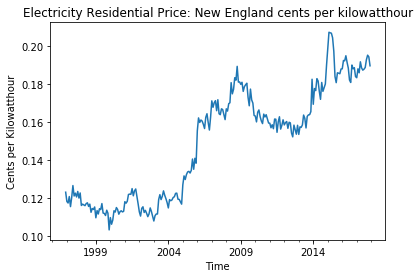

In [156]:
ax = observed_data.plot(x = 'Datetime', y = 'Electricity Price', 
    title = 'Electricity Residential Price: New England cents per kilowatthour',
    legend = False)
ax.set_xlabel('Time')
ax.set_ylabel('Cents per Kilowatthour')
ax.format_xdata = mdates.DateFormatter('%Y-%m')

# Forecasts 2017

Link used to understand ARIMA forecasts

http://www-stat.wharton.upenn.edu/~stine/insr260_2009/lectures/arma_forc.pdf


## ARIMA model

P = number of lags for auto regressive

Q = number of lags for moving average

$y_t = \mu + \phi_1 y_{t-1} + ... +\phi_p y_{t-p}+ a_t -\theta_1 a_{t-1}-...-\theta_q a_{t-q}$

$a_t \sim N(0, \sigma^2)$

If fitting a model with differencing of 1:

$z_t = y_t - y_{t-1}$

$z_t = \mu + \phi_1 z_{t-1} + ... +\phi_p z_{t-p}+ a_t -\theta_1 a_{t-1}-...-\theta_q a_{t-q}$

$\epsilon_t \sim N(0, \sigma^2)$

Need to estimate posterior for $\sigma^2$, $\phi_p$, $\theta_q$, $\mu$ for $p=1, ...,P$ and $q=1,...,Q$ 

Priors: 

$p(\mu) = 1$ 

$\phi_p \sim N(0, 100)$ for i in $p=1, ...,P$

$\theta_q \sim N(0, 100)$ for i in $q=1, ...,Q$

$\sigma^2 \sim \frac{1}{\sigma^2}$ (Jeffrey's Prior) 



## Seasonal Arima 
$\text{ARIMA}(1, 1, 0)\times\text{ARIMA}(1, 1, 0)_{12}$


$z_t = y_t - y_{t-1} + (y_{t-12}-y_{t-13})$


$(1-B^{12})(1-B)x_t = (x_t -x_{t-1}) - (x_{t-12}-x_{t-13})$


If we let zt = xt - μ (for simplicity), multiply the two AR components and push all but zt to the right side we get zt = φ1zt-1 + Φ1zt-12 + (-Φ1φ1)zt-13 + wt.



In [269]:
# ARIMA Model 
#https://github.com/jeffalstott/pystan_time_series/blob/master/stan_models/ARIMA.stan
stan_code = """
data {

    int T; // number of time steps
    int K; // Number of time series
    int T_new; // number of time steps to forecast
    int<lower=0,upper=T-1> P; // Number of lags for AR element
    int<lower=0,upper=T-1> P_S; // Number of lags for seasonal AR
    int<lower=0,upper=T-1> Q; // number of lags for MA 

    matrix[T, K] Y; // data to model

    // priors
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;

    vector[P] phi_prior_location;
    vector[P] phi_prior_scale;

    real theta_prior_location;
    real theta_prior_scale;
}

transformed data {
    matrix[T,P] Y_lagged[K];
    
    for (k in 1:K){
        Y_lagged[k] = rep_matrix(0,T,P);
        for (p in 1:P){
            Y_lagged[k, p+1:T,p] = Y[1:T-p,k];
        }
    } 
}

parameters {
    vector[K] mu;
    vector<lower=0>[K] sigma;
    matrix[K,P] phi;
    matrix[K,P_S] phi_s;
    matrix<lower=-1, upper=1>[K,Q] theta;
    
}

model {
    matrix[T,K] err;
    matrix[T,K] nu;
    matrix[T, K] Z;
    
    //mu ~ normal(mu_prior_location, mu_prior_scale);
    //sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    //sigma ~ inv_gamma(sigma_prior_location, sigma_prior_scale);
    increment_log_prob(-log(sigma)); // equivalent to jeffrey's prior
    
    for (p in 1:P){
        phi[:,p] ~ normal(phi_prior_location[p], phi_prior_scale[p]);
    }
    for (p in 1:P_S){
        phi_s[:,p] ~ normal(phi_prior_location[p], phi_prior_scale[p]);
    }
    for (q in 1:Q){
        theta[:,q] ~ normal(theta_prior_location, theta_prior_scale);
    }

    for (k in 1:K) {
        nu[:,k] = rep_vector(mu[k], T);
        Z[:,k]  = Y[:,k] - nu[:,k];
        
        for (t in 14:T){
            nu[t,k] = mu[k] + phi[k,1]*Z[t-1,k] + phi_s[k,1]*Z[t-12,k] -phi_s[k,1]*phi[k,1]*Z[t-13,k];

            err[t,k] = Y[t,k] - nu[t,k];
        }
        err[14:,k] ~ normal(0, sigma[k]);
    }
}
generated quantities{
    matrix[T+T_new, K] y_pred;
    matrix[T+T_new, K] nu2;
    matrix[T+T_new-13,K] nu;
    //vector[T] log_lik;
    matrix[T+T_new, K] Z;

    for (k in 1:K){
        nu[:T,k] = rep_vector(mu[k], T);
        Z[:T,k]  = Y[:,k] - nu[:T,k];
        for (t in 14:(T+T_new)){
            if (t<=T){ //Predict
                nu2[t,k] = mu[k] + phi[k,1]*Z[t-1,k] + phi_s[k,1]*Z[t-12,k] -phi_s[k,1]*phi[k,1]*Z[t-13,k];
            }
            
            if (t>T){//Forecast
                nu2[t,k] = mu[k] + phi[k,1]*Z[t-1,k] + phi_s[k,1]*Z[t-12,k] -phi_s[k,1]*phi[k,1]*Z[t-13,k];
                Z[t,k] = nu2[t,k] - mu[k];

            }
            y_pred[t, k] = normal_rng(nu2[t,k], sigma[k]);
            
      }        
    }
} 
 
"""

In [268]:
# ARIMA Model 
#https://github.com/jeffalstott/pystan_time_series/blob/master/stan_models/ARIMA.stan
stan_code = """
data {

    int T; // number of time steps
    int K; // Number of time series
    int T_new; // number of time steps to forecast
    int<lower=0,upper=T-1> P; // Number of lags for AR element
    int<lower=0,upper=T-1> Q; // Number of lags for MA element

    matrix[T, K] Y; // data to model

    // priors
    real mu_prior_location;
    real mu_prior_scale;

    real sigma_prior_location;
    real sigma_prior_scale;

    vector[P] phi_prior_location;
    vector[P] phi_prior_scale;

    real theta_prior_location;
    real theta_prior_scale;
}

transformed data {
    matrix[T,P] Y_lagged[K];
    
    for (k in 1:K){
        Y_lagged[k] = rep_matrix(0,T,P);
        for (p in 1:P){
            Y_lagged[k, p+1:T,p] = Y[1:T-p,k];
        }
    } 
}

parameters {
    vector[K] mu;
    vector<lower=0>[K] sigma;
    matrix[K,P] phi;
    matrix<lower=-1, upper=1>[K,Q] theta;
    
}

model {
    matrix[T,K] err;
    matrix[T,K] nu;
    
    //mu ~ normal(mu_prior_location, mu_prior_scale);
    //sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    //sigma ~ inv_gamma(sigma_prior_location, sigma_prior_scale);
    increment_log_prob(-log(sigma)); // equivalent to jeffrey's prior
    
    for (p in 1:P){
        phi[:,p] ~ normal(phi_prior_location[p], phi_prior_scale[p]);
    }
    for (q in 1:Q){
        theta[:,q] ~ normal(theta_prior_location, theta_prior_scale);
    }

    for (k in 1:K) {
        nu[:,k] = rep_vector(mu[k], T);

        if (P>0){
            nu[:,k] = nu[:,k] + Y_lagged[k]*phi[k]';
            }

        err[:,k] = Y[:,k] - nu[:,k];

        if (Q>0){
            if (Q>1){
                for (t in 2:Q){
                    nu[t,k] = nu[t,k] + theta[k,1:t-1]*err[1:t-1, k];
                    err[t,k] = Y[t,k] - nu[t,k];
                }
            }
            for (t in 1+Q:T){
                nu[t,k] = nu[t,k] + theta[k]*err[t-Q:t-1,k];
                err[t,k] = Y[t,k] - nu[t,k];
                }
        }

        err[1+max(P,Q):,k] ~ normal(0, sigma[k]);
    }
}
generated quantities{
    matrix[T+T_new, K] y_pred;
    matrix[T+T_new,K] err;
    matrix[T+T_new, P] y_pred_lagged;
    matrix[T+T_new,K] nu;
    vector[T] log_lik;
    

    for (k in 1:K){
        err[:,k] = rep_vector(0, T+T_new);
        y_pred_lagged[1:T] = Y_lagged[k,1:T];
        for (t in 1:(T+T_new)){
            if (t<=T){ //Predict
                //nu[t,k] = mu[k];
                nu[t,k] = mu[k] + Y_lagged[k, t]*phi[k]';
                err[t,k] = Y[t,k]-nu[t,k];
                log_lik[t] = normal_log(Y[t,k], nu[t,k], sigma[k]);
            }
            if (t>T){//Forecast
                for (p in 1:P){
                    y_pred_lagged[t,p] = y_pred[t-p,k];
                }
                nu[t,k] = mu[k] + y_pred_lagged[t]*phi[k]';
                

            }
            
            if (Q>0){
                    if (t>Q){
                        nu[t,k] = nu[t,k] + theta[k]*err[t-Q:t-1, k];
                    }
                    if (t<Q){
                        if (t>1){
                            nu[t,k] = nu[t,k] + theta[k, 1:t-1]*err[1:t-1, k];
                        }
                    }
    
            }
            y_pred[t, k] = normal_rng(nu[t,k], sigma[k]);
            
      }        
    }
} 
"""

## Split data into training and testing sets
Use 2016 - 2017 as the test

In [124]:
#path_model = figpath + 'arima(2,1,2)_seasonal/'
#text_file = open(path_model+"diagnositics.txt", "w")


In [264]:
y = list(observed_data['Electricity Price'])
n = len(y)
forecast_length = 24
train = observed_data[:-forecast_length]
test = observed_data[-forecast_length:]
train_y = list(train['Electricity Price'])
z_1 = [y[i] - y[i-1] for i in range(1,len(y))] # data with differencing of 1 lag
z_1_train = z_1[:-forecast_length]
z_1_test = z_1[-forecast_length:]
dates = list(observed_data.Datetime.map(lambda x: x.strftime('%Y-%m')))
dates_forecast = list(forcast_eia.Datetime.map(lambda x: x.strftime('%Y-%m')))[:12]

# Set P and Q
P = 1
Q =0
P_s = 1
y = list(observed_data['Electricity Price'])
S = 12
z = [y[i]-y[i-1] - (y[i-S]-y[i-(S+1)]) for i in range(S+1, len(y))]
z_train = z[:-forecast_length]
z_test = z[-forecast_length:]

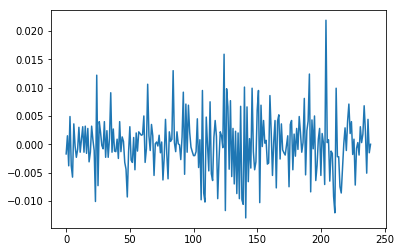

In [244]:
plt.plot(z)

In [265]:
m_data = {'T':len(z_1_train), 'K':1, 'P':P, 'Q':Q, 'P_S':1, 
          'Y':np.asarray(z_1_train).reshape(len(z_1_train), 1),
           "mu_prior_location": 0, 'mu_prior_scale':100, 
          'sigma_prior_location': .1, 'sigma_prior_scale':1, 
           'phi_prior_location':[0]*P, 'phi_prior_scale':[100]*P, 
          'theta_prior_location':0, 'theta_prior_scale':100, 
          'T_new': forecast_length}


In [270]:
iterations = 3000
warmup = 1000
fit = pystan.stan(model_code=stan_code, data=m_data,
                  iter=iterations, warmup = warmup, chains=3)



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_449ecd7558e14adfd40a7ab8526985ba NOW.


In [271]:
summary_dic = fit.summary()
summary_dic

df = pd.DataFrame(summary_dic['summary'], columns = summary_dic['summary_colnames'],
                  index=summary_dic['summary_rownames'])


In [274]:
df.head(30)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu[1],0.000333,0.000004,0.000326,-0.000299,0.000111,0.000337,0.000548,0.000969,5922.454215,0.999547
sigma[1],0.004165,0.000003,0.000203,0.003789,0.004024,0.004154,0.004296,0.004589,3526.119293,1.000616
"phi[1,1]",-0.220391,0.001138,0.068524,-0.352970,-0.266846,-0.221154,-0.174007,-0.087141,3628.324566,1.001375
"phi_s[1,1]",0.287149,0.001225,0.073709,0.145997,0.236321,0.288336,0.335162,0.435935,3619.667243,1.000702
"y_pred[1,1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"y_pred[2,1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"y_pred[3,1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"y_pred[4,1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"y_pred[5,1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"y_pred[6,1]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [286]:
# get the 2.5% and 97.5% and the mean of the posterior over time 
prediction = [np.percentile(fit.extract(permuted=True)['y_pred'][13:], q=[2.5, 97.5], axis=0), 
              np.mean(fit.extract(permuted=True)['y_pred'], axis = 0)[13:]]


/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [293]:
prediction[1].shape

(239, 1)

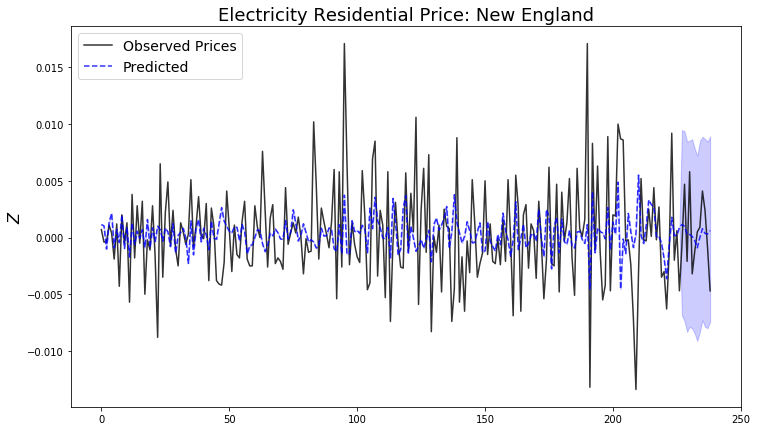

In [290]:
prediction_plots(dates, z_1[S+1:], prediction, 12, xlim = None, differenced = True, 
                 save = False,ylab = r'$Z$', path = path_model+'forecast.png', 
                 n_months_to_show = 10)


## Convert differenced prediction to original units 
for 1:T 

$\hat{y_t} = y_{t-1}+\hat{z}_t$


for T+1:T+T_new 

$\hat{y_{t+1}} = y_t + \hat{z}_{t+1}$

$\hat{y_{t+2}} = y_t + \hat{z}_{t+1} + \hat{z}_{t+2}$


In [298]:
def transform_differenced_seasonal(z, y, T, forecast_length, d=1, S=1):
    
    y_hat = {}
    if S>0:
        for t in range(T): #0:T-1
            y_hat[t] = z[t] + y[t+S+1] + (y[t-S]-y[t-S-1])

        # create dictionary that contains the training data followed by the forecast
        y_train_forecast = {t:y[t] for t in range(T)}
        T_new = T + forecast_length
        y_train_forecast[T] = z[T] + y[T-1] + (y[T-1-S] - y[T-1-S-1])
        for t in range(T+1, T_new): # T+1:T_new
            y_train_forecast[t] = z[t] + y_train_forecast[t-1] + (y_train_forecast[t-S] - y_train_forecast[t-S-1])
        for t in range(T,T_new): # merge forecast back with y_hat
            y_hat[t] = y_train_forecast[t]
    return y_hat
def transform_differenced(z, y, T, forecast_length, d=1, S=1):
    
    y_hat = {}
    for t in range(1,T): #0:T-1
        y_hat[t] = z[t] + y[t-1]

    # create dictionary that contains the training data followed by the forecast
    y_train_forecast = {t:y[t] for t in range(1,T)}
    T_new = T + forecast_length
    y_train_forecast[T] = z[T] + y[T-1] 
    for t in range(T+1, T_new-13): # T+1:T_new
        y_train_forecast[t] = z[t] + y_train_forecast[t-1]
    for t in range(T,T_new-13): # merge forecast back with y_hat
        y_hat[t] = y_train_forecast[t]
    return y_hat

(200, 250)

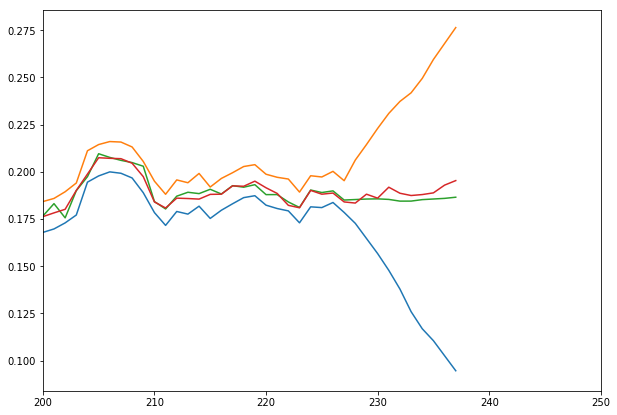

In [313]:
y_hat_lower = transform_differenced(prediction[0][0], y[S+1:], len(z_1_train), 24)
y_hat_upper = transform_differenced(prediction[0][1], y[S+1:], len(z_1_train), 24)
y_hat = transform_differenced(prediction[1], y[S+1:], len(z_1_train), 24)

fig, ax = plt.subplots(figsize = (10,7))
ax.plot(y_hat_lower.values())
ax.plot(y_hat_upper.values())
ax.plot(y_hat.values())

ax.plot(y[13:-2])
ax.set_xlim(200, 250)

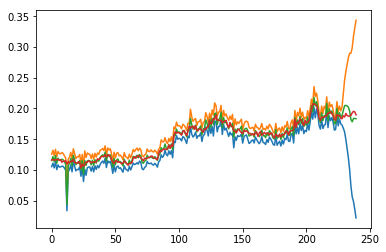

In [133]:
#y_hat_lower = transform_differenced_seasonal(prediction[0][0], y, len(z_train), 12, d=1, S=S)
#y_hat_upper = transform_differenced_seasonal(prediction[0][1], y, len(z_train), 12, d=1, S=S)
#y_hat = transform_differenced_seasonal(prediction[1], y, len(z_train), 12, d=1, S=S)

#plt.plot(y_hat_lower.values())
#plt.plot(y_hat_upper.values())
#plt.plot(y_hat.values())

#plt.plot(y[S+1:])

In [301]:
prediction_transformed = [[list(y_hat_lower.values()), list(y_hat_upper.values())], list(y_hat.values())]


ValueError: cannot reshape array of size 238 into shape (225,)

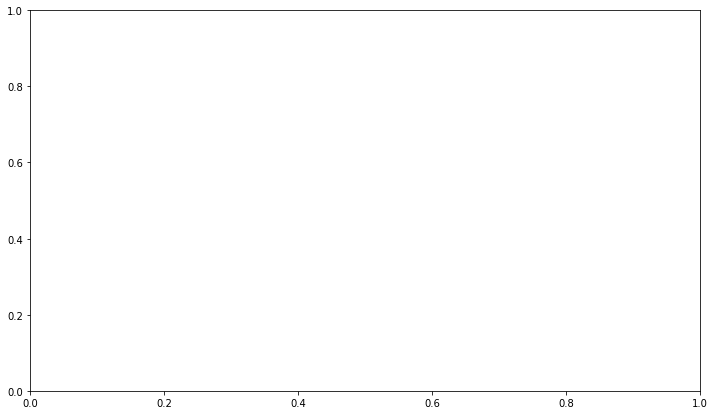

In [304]:
prediction_plots(dates[13:], y[13:], prediction_transformed, 24, xlim = None, ylim = [0, .35], 
                 ylab = 'Price per kWh', differenced = False, save = False, 
                 path = path_model+'forecast_transformed.png', n_months_to_show = 15)


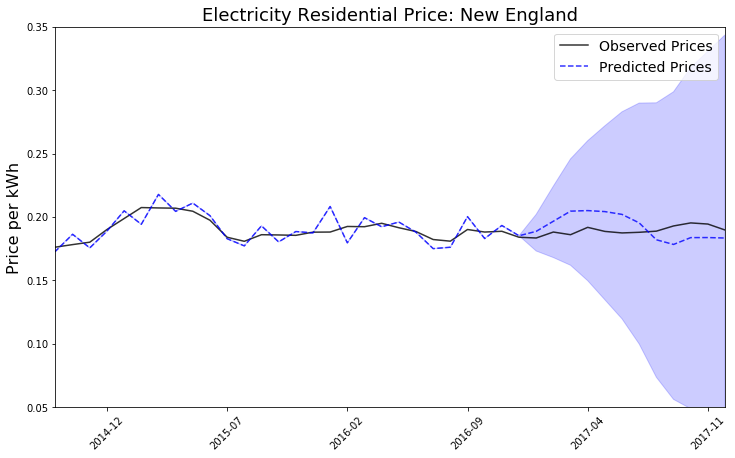

In [136]:
prediction_plots(dates[S+1:], y[S+1:], prediction_transformed, 12, xlim = [200, 239], 
                 ylim = [.05, .35], differenced = False,ylab = 'Price per kWh', 
                 save = True, path = path_model+'forecast_transformed_zoomed2.png', 
                 n_months_to_show = 7)


## Calculate WAIC 

In [137]:
log_lik_data = pd.DataFrame(fit['log_lik'])

In [176]:
# calculate WAIC

# http://kylehardman.com/BlogPosts/View/7
T = len(z_1_train)

# log posterior predictive density
LPPD = sum([df['mean']['log_lik['+str(i)+']'] for i in range(1,T+1)])

# Effective number of parameters
# Version 2, Gelman suggests
n_effective = 0
for i in range(2,T):
    #print(variance(log_lik_data[i].iloc[warmup:]))
    n_effective += variance(log_lik_data[i].iloc[warmup:])


KeyError: 228

In [ ]:
WAIC = -2*(LPPD-n_effective)
WAIC

In [ ]:
LPPD

In [141]:
text_file.write("WAIC: %s '\n'" % WAIC)
text_file.write("N effective: %s'\n'" % n_effective)
text_file.write("LPPD: %s'\n'" % LPPD)


26

## Check for convergance 

In [142]:
df_model_params = df.iloc[:2+P+Q]
param_names = list(df_model_params.index)

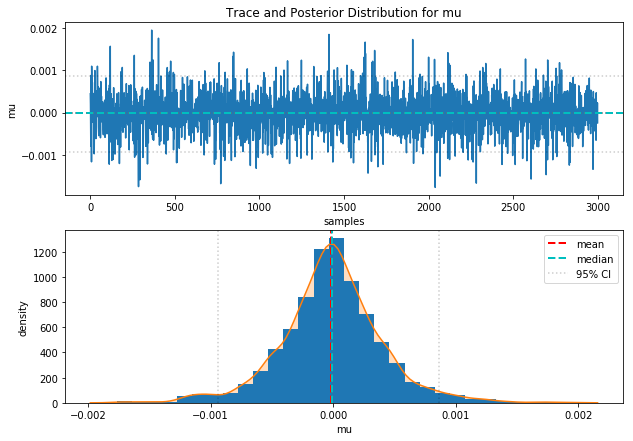

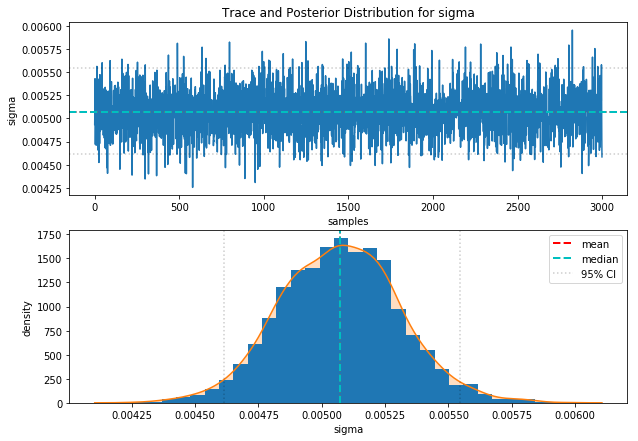

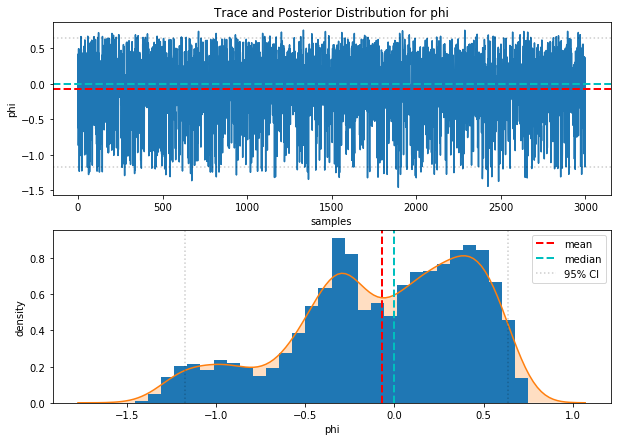

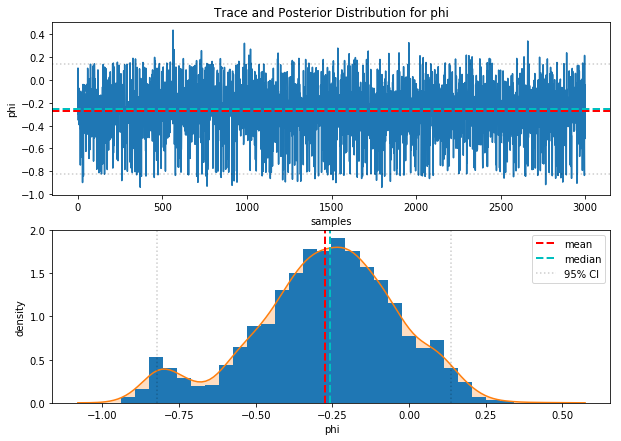

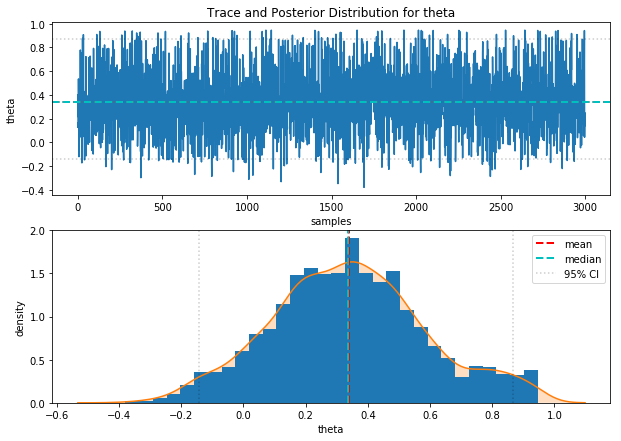

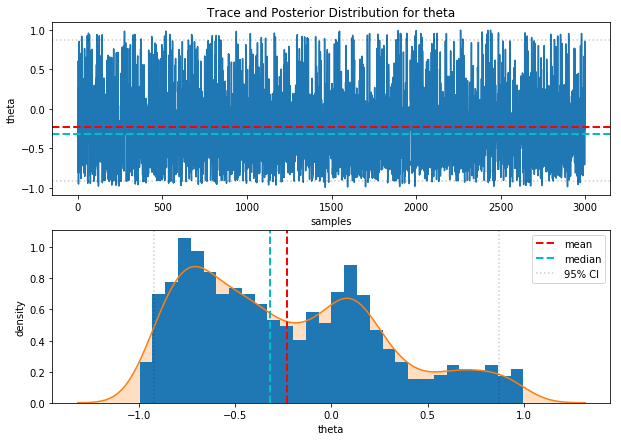

In [143]:
# plot trace plots 
save = True # need to be able to save these plots 
for param in param_names:
    # strip the indexes of the parameter name 
    param_split = param.split('[')
    name = param_split[0]
    if name == 'mu' or name =='sigma':
        path = path_model + name+'_' +'_trace_plot.png'
        plot_trace(fit[name][warmup:warmup+iterations], name, save=save, path = path)
    else:
        get_index = param_split[1].split(']')
        get_k_i = get_index[0].split(',')
        k = int(get_k_i[0])
        i = int(get_k_i[1])
        trace = [fit[name][j][k-1][i-1] for j in range(warmup,warmup+iterations)]
        path = path_model + name+'_' +get_index[0]+'_trace_plot.png'
        plot_trace(trace, name, save=save, path = path)
        
        
        

## Check Residuals 

Text(0.5,1,'Residuals')

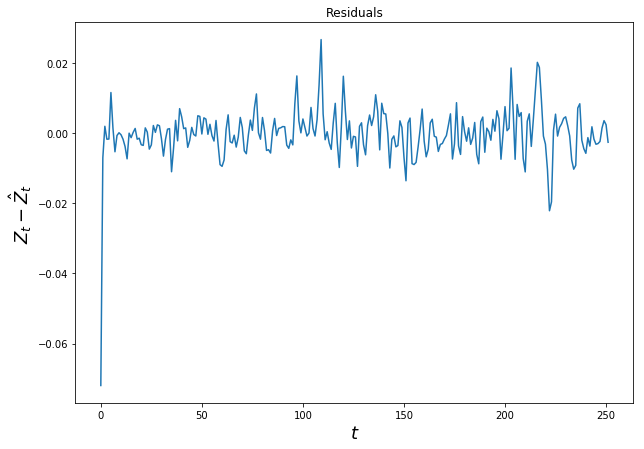

In [203]:
#resid = residuals(y[S+1:], y_hat)
resid = [x - x_hat for x, x_hat in zip(y[1:], y_hat.values())]
#resid = [x - x_hat for x, x_hat in zip(y[S+1:], y_hat.values())]
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot(resid)
ax.set_ylabel(r'$Z_t - \hat{Z}_t$', fontsize = 18)
ax.set_xlabel(r'$t$', fontsize = 18)
#ax.set_ylim((-2,2))
ax.set_title('Residuals')
#fig.savefig(path_model+'residuals.png')

/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


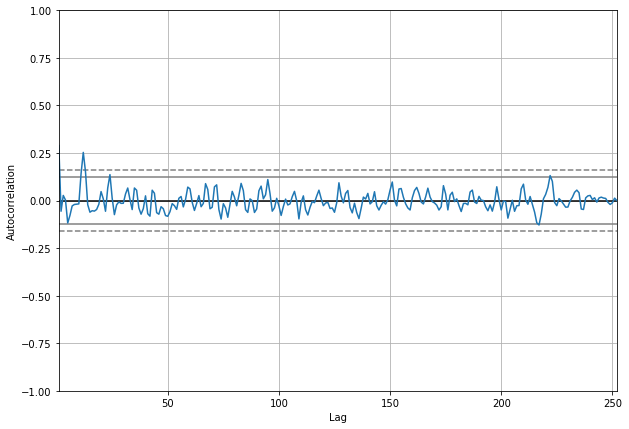

In [198]:
# residual autocorrelation
fig = plt.figure(figsize = (10,7))
autocorrelation_plot(resid)
#fig.savefig(path_model+'residual_autocorrelation.png')

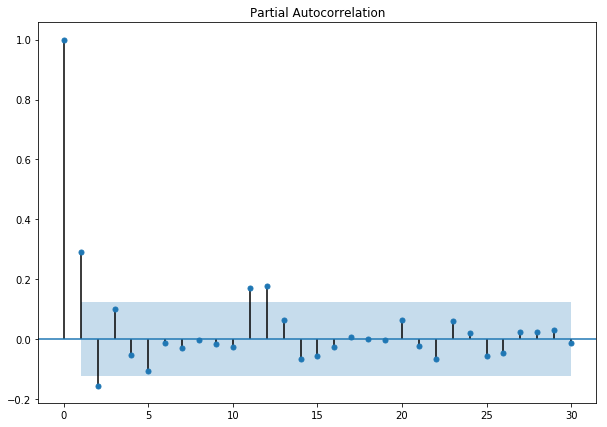

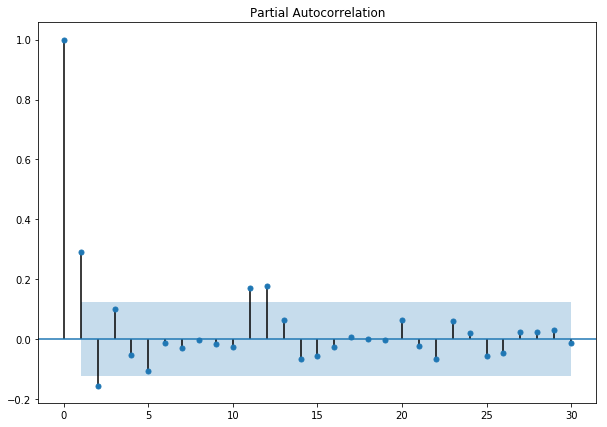

In [199]:
# residual partial autocorrelation

fig, ax = plt.subplots(figsize = (10,7))
plot_pacf(resid, lags=30,ax=ax)
#fig.savefig(path_model+'residual_partial_autocorrelation.png')

In [204]:
# MSE 

mse_total = sum([r**2 for r in resid])/len(resid)
print('mse total', mse_total*100)

mse_forecast = sum([r**2 for r in resid[:-forecast_length]])/len(resid[:-forecast_length])
print('forecast mse', mse_forecast*100)
#text_file.write("MSE Total: %s '\n'" % mse_total)
#text_file.write("MSE Forecast: %s '\n'" % mse_forecast)

#text_file.close()

mse total [0.00557837]
forecast mse [0.00581333]


In [207]:
4.48*10**(-3)

0.0044800000000000005

# Forecast 2018

In [96]:
# Set P and Q
P = 2
Q =0


In [97]:
m_data = {'T':len(z_1), 'K':1, 'P':P, 'Q':Q, 'Y':np.asarray(z_1).reshape(len(z_1), 1),
           "mu_prior_location": 0, 'mu_prior_scale':100, 
          'sigma_prior_location': .1, 'sigma_prior_scale':1, 
           'phi_prior_location':[0]*P, 'phi_prior_scale':[100]*P,
          'theta_prior_location':0, 'theta_prior_scale':100, 'T_new': forecast_length}


In [98]:
iterations = 3000
warmup = 1000
fit = pystan.stan(model_code=stan_code, data=m_data,
                  iter=iterations, warmup = warmup, chains=3)



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_533c183fbfda36b2c60ffeba2a0bfedc NOW.


KeyboardInterrupt: 

In [ ]:
summary_dic = fit.summary()
summary_dic

df = pd.DataFrame(summary_dic['summary'], columns = summary_dic['summary_colnames'], 
                  index=summary_dic['summary_rownames'])
df.head(2+P+Q)

In [ ]:
# get the 2.5% and 97.5% and the mean of the posterior over time 
prediction = [np.percentile(fit.extract(permuted=True)['y_pred'], q=[2.5, 97.5], axis=0), 
              np.mean(fit.extract(permuted=True)['y_pred'], axis = 0)]


In [ ]:
z_lower = pd.DataFrame(prediction[0][0])
hat_y_lower = {}
for t in range(len(z_1)-1): 
    hat_y_lower[t+1] = y[t]+z_lower.iloc[t]

hat_y_lower[len(z_1)] = y[-1] + z_lower.iloc[len(z_1)-1]
for t in range(len(z_1), len(z_1)+forecast_length): 
    hat_y_lower[t+1] = hat_y_lower[t] + z_lower.iloc[t] 
    
z_upper = pd.DataFrame(prediction[0][1])
hat_y_upper = {}
for t in range(len(z_1)-1): 
    hat_y_upper[t+1] = y[t]+z_upper.iloc[t]

hat_y_upper[len(z_1)] = y[-1] + z_upper.iloc[len(z_1)-1]
for t in range(len(z_1), len(z_1)+forecast_length): 
    hat_y_upper[t+1] = hat_y_upper[t] + z_upper.iloc[t] 
    
z = pd.DataFrame(prediction[1])
hat_y = {}
for t in range(len(z_1)-1): 
    hat_y[t+1] = y[t]+z.iloc[t]

hat_y[len(z_1)] = y[-1] + z.iloc[len(z_1)-1]
for t in range(len(z_1), len(z_1)+forecast_length): 
    hat_y[t+1] = hat_y[t] + z.iloc[t] 

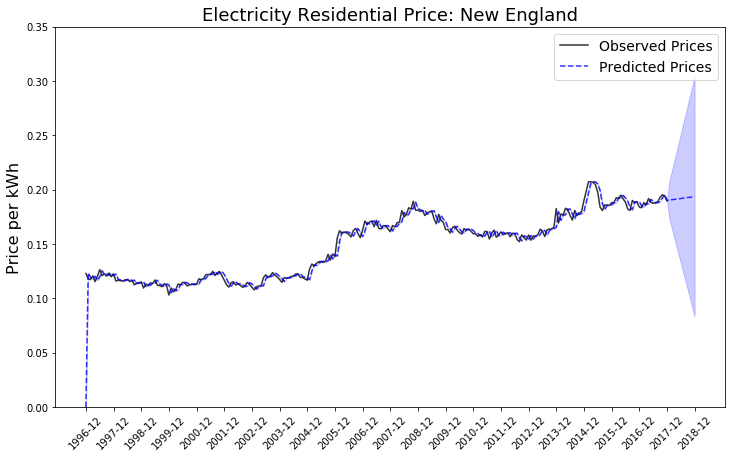

In [37]:
prediction_transformed = [[[0] + list(hat_y_lower.values()), [0] + 
                           list(hat_y_upper.values())],
                          [0]+list(hat_y.values())]
prediction_plots(dates, y, prediction_transformed, 12, xlim = None, ylim = [0, .35], 
                 ylab = 'Price per kWh', differenced = False, save = False, 
                 path = path_model+'forecast_2018_transformed.png', 
                 n_months_to_show = 12, dates_forecast = dates_forecast)

## Calculate WAIC 

In [38]:
log_lik_data = pd.DataFrame(fit['log_lik'])

In [39]:
# calculate WAIC

# http://kylehardman.com/BlogPosts/View/7
T = len(z_1_train)

# log posterior predictive density
LPPD = sum([df['mean']['log_lik['+str(i)+']'] for i in range(1,T+1)])

# Effective number of parameters
# Version 2, Gelman suggests
n_effective = 0
for i in range(2,T):
    #print(variance(log_lik_data[i].iloc[warmup:]))
    n_effective += variance(log_lik_data[i].iloc[warmup:])


In [40]:
WAIC = -2*(LPPD-n_effective)
WAIC

-1925.3429449700905

In [41]:
n_effective

5.771776315801566

In [42]:
#text_file.write("WAIC: %s '\n'" % WAIC)
#text_file.write("N effective: %s'\n'" % n_effective)
#text_file.write("LPPD: %s'\n'" % LPPD)


## Check for convergance 

In [43]:
df_model_params = df.iloc[:2+P+Q]
param_names = list(df_model_params.index)

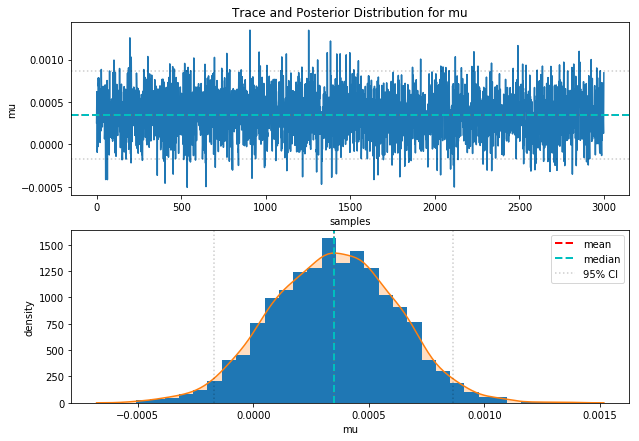

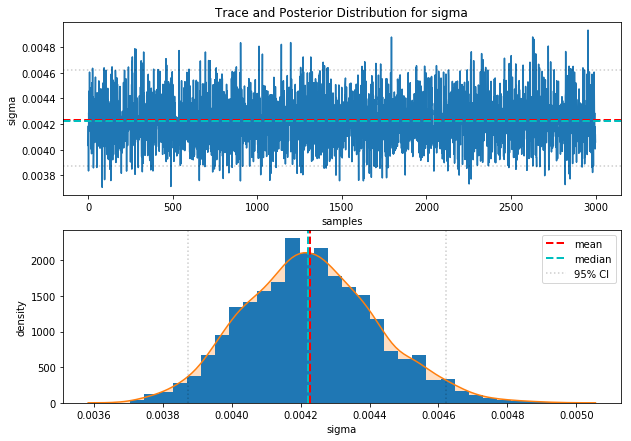

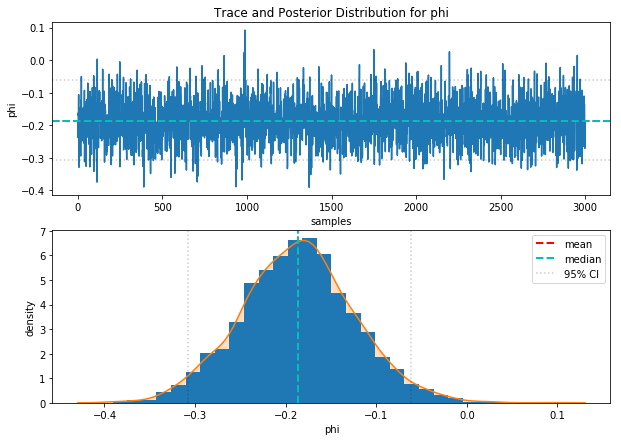

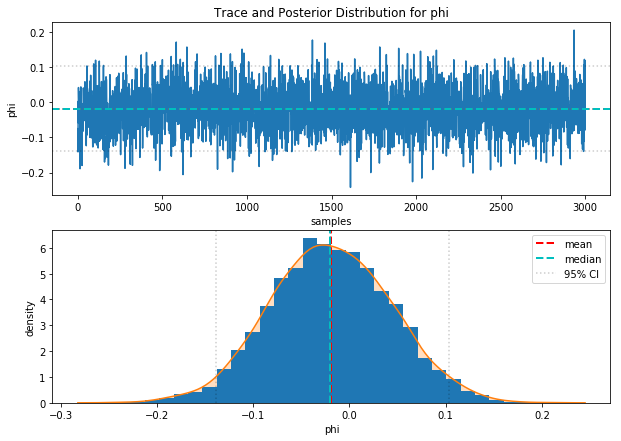

In [44]:
# plot trace plots 
save = False # need to be able to save these plots 
for param in param_names:
    # strip the indexes of the parameter name 
    param_split = param.split('[')
    name = param_split[0]
    if name == 'mu' or name =='sigma':
        path = path_model + name+'_' +'_trace_plot.png'
        plot_trace(fit[name][warmup:warmup+iterations], name, save=save, path = path)
    else:
        get_index = param_split[1].split(']')
        get_k_i = get_index[0].split(',')
        k = int(get_k_i[0])
        i = int(get_k_i[1])
        trace = [fit[name][j][k-1][i-1] for j in range(warmup,warmup+iterations)]
        path = path_model + name+'_' +get_index[0]+'_trace_plot.png'
        plot_trace(trace, name, save=save, path = path)
        
        
        

## Check Residuals 

Text(0.5,1,'Residuals')

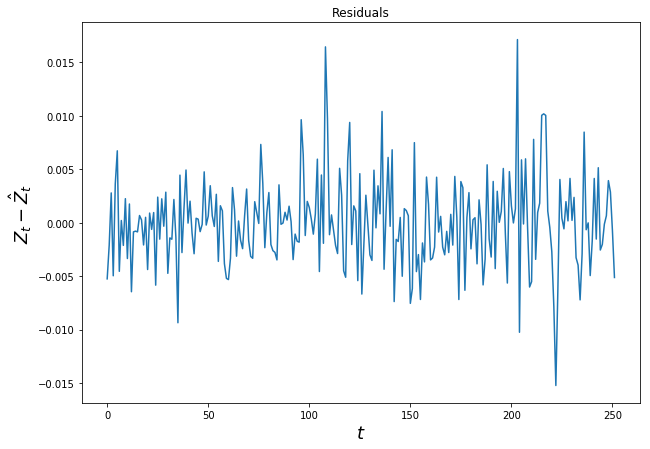

In [45]:
resid = residuals(z_1, prediction[1])
fig, ax = plt.subplots(figsize = (10, 7))
ax.plot(resid)
ax.set_ylabel(r'$Z_t - \hat{Z}_t$', fontsize = 18)
ax.set_xlabel(r'$t$', fontsize = 18)
#ax.set_ylim((-2,2))
ax.set_title('Residuals')
#fig.savefig(path_model+'residuals.png')

/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


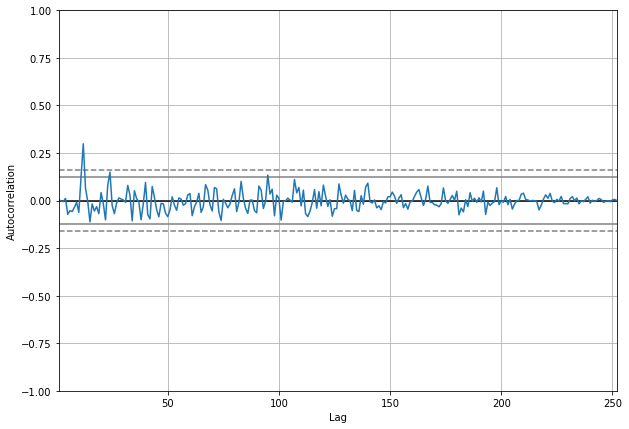

In [46]:
# residual autocorrelation
fig = plt.figure(figsize = (10,7))
autocorrelation_plot(resid)
#fig.savefig(path_model+'residual_autocorrelation.png')

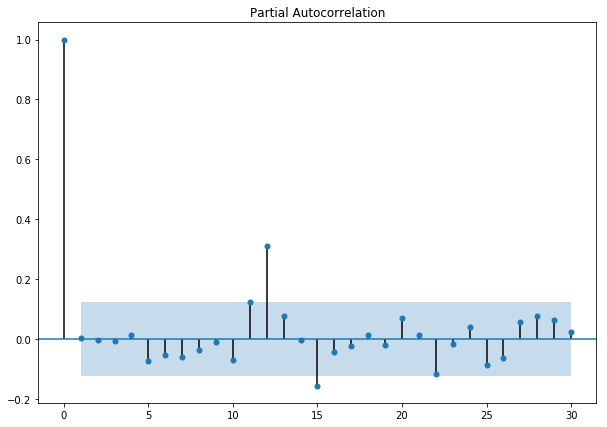

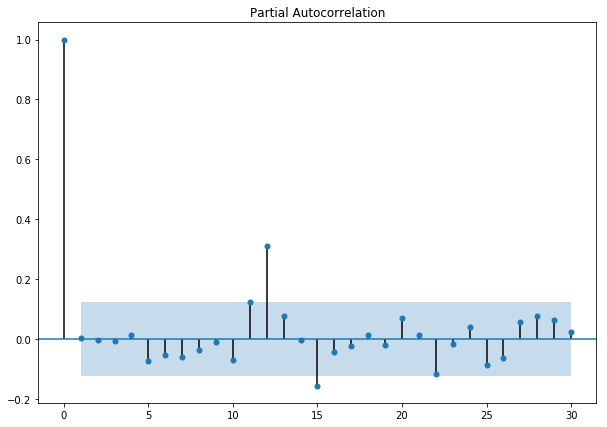

In [47]:
# residual partial autocorrelation

fig, ax = plt.subplots(figsize = (10,7))
plot_pacf(resid, lags=30,ax=ax)
#fig.savefig(path_model+'residual_partial_autocorrelation.png')

In [48]:
# MSE 

mse_total = sum([r**2 for r in resid])/len(resid)
mse_total

#mse_forecast = sum([r**2 for r in resid[:-forecast_length]])/len(resid[:-forecast_length])

#text_file.write("MSE Total: %s '\n'" % mse_total)
#text_file.write("MSE Forecast: %s '\n'" % mse_forecast)

#text_file.close()

array([1.76233704e-05])